# Multi-label text classification with sklearn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))
%matplotlib inline

['Answers.csv', 'Questions.csv', 'Tags.csv', 'database.sqlite']


In [3]:
df_questions = pd.read_csv('../input/Questions.csv', encoding='iso-8859-1')
df_tags = pd.read_csv('../input/Tags.csv', encoding='iso-8859-1')
df_questions.head(n=2)

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,6,5.0,2010-07-19T19:14:44Z,272,The Two Cultures: statistics vs. machine learn...,"<p>Last year, I read a blog post from <a href=..."
1,21,59.0,2010-07-19T19:24:36Z,4,Forecasting demographic census,<p>What are some of the ways to forecast demog...


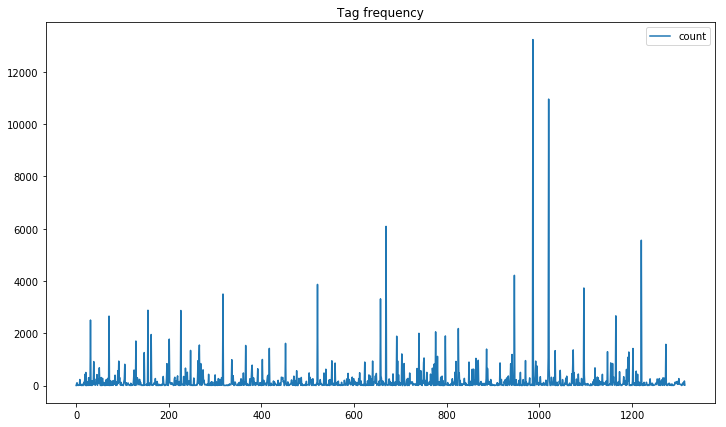

In [4]:
grouped_tags = df_tags.groupby("Tag", sort='count').size().reset_index(name='count')
fig = plt.figure(figsize=(12,10))
grouped_tags.plot(figsize=(12,7), title="Tag frequency")

We will only use the top 100 used tags for our classifiers

In [5]:
num_classes = 100
grouped_tags = df_tags.groupby("Tag").size().reset_index(name='count')
most_common_tags = grouped_tags.nlargest(num_classes, columns="count")
df_tags.Tag = df_tags.Tag.apply(lambda tag : tag if tag in most_common_tags.Tag.values else None)
df_tags = df_tags.dropna()

In [6]:
counts = df_tags.Tag.value_counts()
firstlast = counts[:5].append(counts[-5:])
firstlast.reset_index(name="count")

,index,count
0,r,13236
1,regression,10959
2,machine-learning,6089
3,time-series,5559
4,probability,4217
5,nonlinear-regression,514
6,cox-model,510
7,monte-carlo,504
8,proportion,503
9,algorithms,500


## Data preparation

*  strip html tags
* denormalize tables / combine data frames with questions and tags into a single data frame

In [7]:
import re 

def strip_html_tags(body):
    regex = re.compile('<.*?>')
    return re.sub(regex, '', body)

df_questions['Body'] = df_questions['Body'].apply(strip_html_tags)
df_questions['Text'] = df_questions['Title'] + ' ' + df_questions['Body']

def tags_for_question(question_id):
    return df_tags[df_tags['Id'] == question_id].Tag.values

def add_tags_column(row):
    row['Tags'] = tags_for_question(row['Id'])
    return row

df_questions = df_questions.apply(add_tags_column, axis=1)
df_questions[['Id', 'Text', 'Tags']].head()

,Id,Text,Tags
0,6,The Two Cultures: statistics vs. machine learn...,[machine-learning]
1,21,Forecasting demographic census What are some o...,[forecasting]
2,22,Bayesian and frequentist reasoning in plain En...,[bayesian]
3,31,What is the meaning of p values and t values i...,"[hypothesis-testing, t-test, p-value, interpre..."
4,36,Examples for teaching: Correlation does not me...,[correlation]


## Creating tf-idf feature
* encode labels
* compute tf-idf from questions

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_questions.Tags)
Y = multilabel_binarizer.transform(df_questions.Tags)

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df_questions.Text)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [11]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


In [13]:
def counts(Y):
    formatYtrain = []
    for x in Y:
      k = 0
      for idx, y in enumerate(x):
        if y == 1:
          k =idx
      formatYtrain.append(k)

    a = np.array(formatYtrain)
    unique, counts = np.unique(a, return_counts=True)
    return dict(zip(unique, counts))

In [18]:
d = counts(Y)
print(d)

{0: 8819, 1: 403, 2: 62, 3: 109, 4: 680, 5: 76, 6: 125, 7: 163, 8: 117, 9: 206, 10: 312, 11: 579, 12: 775, 13: 179, 14: 438, 15: 900, 16: 214, 17: 52, 18: 315, 19: 217, 20: 249, 21: 581, 22: 303, 23: 126, 24: 980, 25: 197, 26: 451, 27: 203, 28: 290, 29: 238, 30: 258, 31: 206, 32: 285, 33: 178, 34: 1273, 35: 198, 36: 183, 37: 228, 38: 222, 39: 126, 40: 793, 41: 2437, 42: 691, 43: 350, 44: 532, 45: 325, 46: 288, 47: 256, 48: 469, 49: 203, 50: 383, 51: 357, 52: 212, 53: 245, 54: 384, 55: 666, 56: 429, 57: 1381, 58: 164, 59: 470, 60: 1086, 61: 520, 62: 278, 63: 304, 64: 453, 65: 349, 66: 864, 67: 352, 68: 421, 69: 269, 70: 545, 71: 2723, 72: 266, 73: 559, 74: 7974, 75: 425, 76: 770, 77: 506, 78: 774, 79: 8257, 80: 504, 81: 983, 82: 462, 83: 563, 84: 1097, 85: 3134, 86: 559, 87: 1107, 88: 612, 89: 528, 90: 730, 91: 2300, 92: 448, 93: 594, 94: 1032, 95: 1238, 96: 1348, 97: 531, 98: 5493, 99: 1576}


In [19]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=9000)
X_tfidf_resampled, Y_tfidf_resampled = ros.fit_sample(X_tfidf, Y)

In [21]:
d = counts(Y_tfidf_resampled)
print(d)


{0: 9220, 1: 9220, 2: 9220, 3: 9220, 4: 9220, 5: 9220, 6: 9220, 7: 9220, 8: 9220, 9: 9220, 10: 9220, 11: 9220, 12: 9220, 13: 9220, 14: 9220, 15: 9220, 16: 9220, 17: 9220, 18: 9220, 19: 9220, 20: 9220, 21: 9220, 22: 9220, 23: 9220, 24: 9220, 25: 9220, 26: 9220, 27: 9220, 28: 9220, 29: 9220, 30: 9220, 31: 9220, 32: 9220, 33: 9220, 34: 9220, 35: 9220, 36: 9220, 37: 9220, 38: 9220, 39: 9220, 40: 9220, 41: 9220, 42: 9220, 43: 9220, 44: 9220, 45: 9220, 46: 9220, 47: 9220, 48: 9220, 49: 9220, 50: 9220, 51: 9220, 52: 9220, 53: 9220, 54: 9220, 55: 9220, 56: 9220, 57: 9220, 58: 9220, 59: 9220, 60: 9220, 61: 9220, 62: 9220, 63: 9220, 64: 9220, 65: 9220, 66: 9220, 67: 9220, 68: 9220, 69: 9220, 70: 9220, 71: 9220, 72: 9220, 73: 9220, 74: 9220, 75: 9220, 76: 9220, 77: 9220, 78: 9220, 79: 9220, 80: 9220, 81: 9220, 82: 9220, 83: 9220, 84: 9220, 85: 9220, 86: 9220, 87: 9220, 88: 9220, 89: 9220, 90: 9220, 91: 9220, 92: 9220, 93: 9220, 94: 9220, 95: 9220, 96: 9220, 97: 9220, 98: 9220, 99: 9220}


In [ ]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf_resampled, Y_tfidf_resampled, test_size=0.2, random_state=9000)

In [ ]:
fig = plt.figure(figsize=(20,20))
(ax_test, ax_train) = fig.subplots(ncols=2, nrows=1)
g1 = sns.barplot(x=Y.sum(axis=0), y=multilabel_binarizer.classes_, ax=ax_test)
g2 = sns.barplot(x=y_train_tfidf.sum(axis=0), y=multilabel_binarizer.classes_, ax=ax_train)
g1.set_title("class distribution before resampling")
g2.set_title("class distribution in training set after resampling")

## OneVsRest with different classifiers
use OneVsRest strategy to have one classifier for each class/label

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test_tfidf)))
    print("Hamming score: {}".format(hamming_score(y_pred, y_test_tfidf)))
    print("---")    

In [ ]:
nb_clf = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression()
mn = MultinomialNB()

for classifier in [nb_clf, sgd, lr, mn]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    print_score(y_pred, classifier)